In [ ]:
def identify_outliers(df, column, window_size, n_sigmas):
    """
    Identify outliers in a DataFrame column based on rolling statistics.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    column (str): The name of the column to analyze for outliers.
    window_size (int): The size of the rolling window to calculate statistics.
    n_sigmas (int): The number of standard deviations to use for determining outliers.

    Returns:
    pandas.DataFrame: A DataFrame containing the original data, rolling mean, rolling std,
                      upper bound, lower bound, and a boolean indicating if each point is an outlier.
    """

    # Ensure the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"Column {column} not found in DataFrame")

    # Copy only the relevant column to avoid modifying the original DataFrame
    analysis_df = df[[column]].copy()

    # Calculate rolling mean and standard deviation
    rolling_stats = analysis_df.rolling(window=window_size).agg(['mean', 'std'])
    rolling_stats.columns = rolling_stats.columns.droplevel()

    # Join rolling statistics back to the analysis DataFrame
    analysis_df = analysis_df.join(rolling_stats)

    # Calculate the upper and lower bounds for outlier detection
    analysis_df["upper"] = analysis_df["mean"] + n_sigmas * analysis_df["std"]
    analysis_df["lower"] = analysis_df["mean"] - n_sigmas * analysis_df["std"]

    # Identify outliers
    analysis_df["is_outlier"] = (analysis_df[column] > analysis_df["upper"]) | (analysis_df[column] < analysis_df["lower"])

    return analysis_df


# Finding the Changepoint– using CUSUM


In [ ]:
!pip install kats

Kats is a toolkit to analyze time series data. You can read more about it [here](https://facebookresearch.github.io/Kats/), we will use one of its functionalities that is "detect various patterns on time series data, including seasonalities, outlier, change point, and slow trend changes."

## Note to m1/m2 mac users: 
If you are using an ARM-based system like the Apple M1 or M2 Mac, it's possible that some Python packages, including kats and its dependencies, might not be fully compatible with your architecture. Which is the case on this machine, for this reason, I will try to use alternative packages in this repo. 

<Axes: title={'center': "Apple's stock in 2020"}, xlabel='Date'>

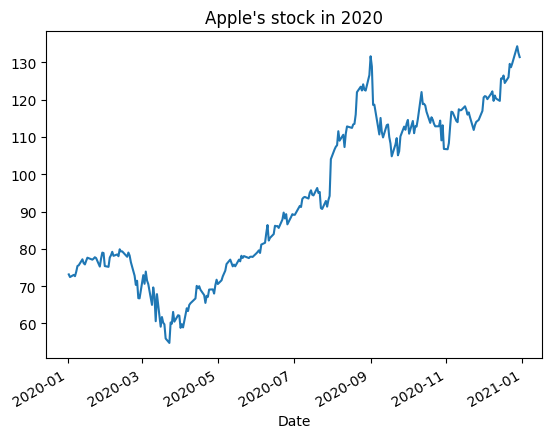

In [1]:
import yfinance as yf
import pandas as pd

df = yf.download("AAPL", 
                 start="2020-01-01", 
                 end="2020-12-31", 
                 progress=False)["Adj Close"]
df.plot(title="Apple's stock in 2020")

## Using ruptures
ruptures is a Python library specifically designed for change point detection.

In [2]:
df.head()

Date
2020-01-02    73.152649
2020-01-03    72.441460
2020-01-06    73.018700
2020-01-07    72.675278
2020-01-08    73.844360
Name: Adj Close, dtype: float64

In [3]:
pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [4]:
import ruptures as rpt
import matplotlib.pyplot as plt

To use this data (df --- Series with dates as the index and adjusted close prices as the values) with the ruptures library for change point detection, you need to convert this Series to a two-dimensional NumPy array. 

In [5]:
# Convert the pandas Series to a NumPy array and reshape it to be 2-dimensional
values = df.values.reshape(-1, 1)

In [6]:
# Change point detection
# PELT stands for "Pruned Exact Linear Time": It is an algorithm used for detecting change points in a time series, and it's known for being particularly efficient in terms of computational time. 
algo = rpt.Pelt(model="l2").fit(values)
# the model is using the L2 cost function, specifically, is based on the squared differences between the data points and the mean of those points. When combined, the PELT method with an L2 cost function is used to efficiently detect points in time where there is a significant change in the mean value of the data.
result = algo.predict(pen=5000)
# Increasing penalty value will reduce the number of change points detected. This makes the algorithm less sensitive to smaller changes.

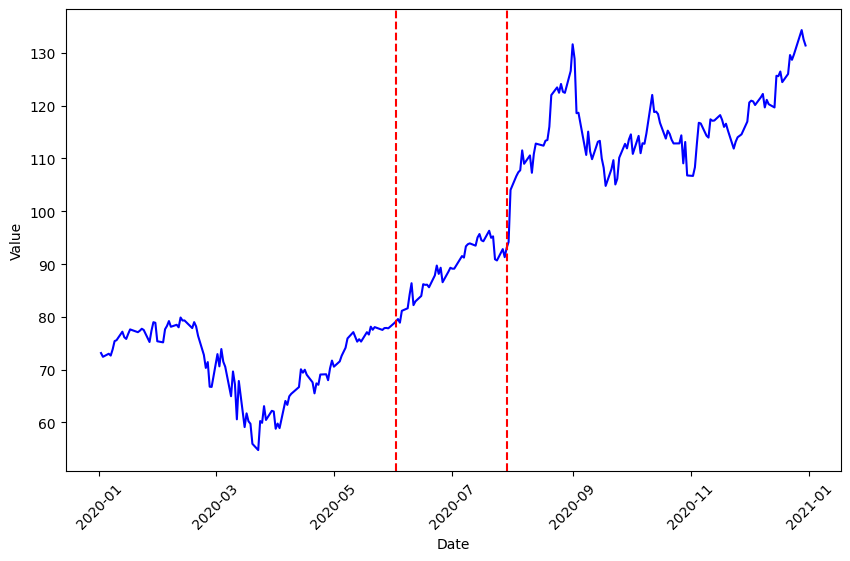

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df.values, 'b-', label='Data')
for cp in result[:-1]:  # Exclude the last element as it typically points to the end of the data
    ax.axvline(df.index[cp-1], color='r', linestyle='--', label='Change Point')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [28]:
# Where is a structural break? 
df.index[result[-1]-1]

Timestamp('2020-03-13 00:00:00')

This is the time were there might be a structural break in the series downloaded from yahoo finance

# Differences with the figure in textbook

Different algorithms might make different statistical assumptions about the data. Understanding these assumptions can help in choosing the right method and interpreting the results correctly. This might be something to discuss further in your projects. It is important to note in terms of applications that both libraries are not the same. The CUSUMDetector in kats specifically looks for changes in the mean of the data, with the ability to specify the direction of change (like "increase"). On the other hand, ruptures offers a variety of algorithms (like PELT, Binary Segmentation, etc.) and can detect changes in both mean, variance, and other properties, depending on the chosen model.



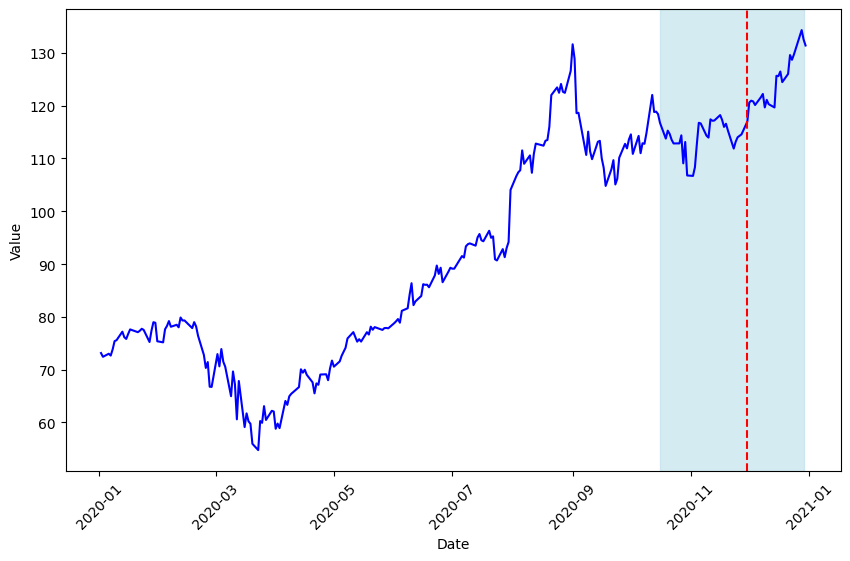

In [18]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Assuming df is your pandas Series with time series data
values = df.values.reshape(-1, 1)

# Define the window of interest
start, end = 200, 250
values_window = values[start:end]

# Change point detection within the specified window
algo = rpt.Pelt(model="l2").fit(values_window)
result = algo.predict(pen=1000)

# Adjust the result indices to reflect the original data indices
result_adjusted = [r + start for r in result]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df.values, 'b-', label='Data')

# Highlight the window
ax.axvspan(df.index[start], df.index[end], color='lightblue', alpha=0.5)

for cp in result_adjusted[:-1]:  # Exclude the last element which is just the end of the window
    ax.axvline(df.index[cp], color='r', linestyle='--', label='Change Point')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.xticks(rotation=45)
plt.show()


# Alternative methods

The Python package statsmodels can be used to detect structural shifts or breaks in time series data, like stock prices from Yahoo Finance. However, the process requires more than just basic plotting of the data. 

statsmodels provides tools for conducting statistical tests to identify structural breaks. One common method is the Chow Test, but statsmodels doesn't have a direct implementation of this. 

## What is the Chow test?
The Chow Test is a statistical test used to determine whether there is a structural break in a time series dataset at a specific point in time. The test is commonly used in econometrics to test for the presence of a structural change in a linear regression model at a given period. 

You can learn more about Chow test [here](https://www.youtube.com/watch?v=361GUToI6xk).

Note: Keep in mind that detecting structural breaks in financial time series data can be complex and the interpretation of the results should be done carefully. You can do further reading on this using multiple resource wooldridge textbook that is available in the library. 

In [20]:
!pip install statsmodels

In [ ]:
import yfinance as yf
import statsmodels.api as sm
import numpy as np
from scipy import stats

# Download data
df = yf.download("AAPL", start="2020-01-01", end="2020-12-31", progress=False)["Adj Close"]

# Split the data at the specified point
split_date = '2020-03-13'
df_before = df[:split_date]
df_after = df[split_date:]

# Add a constant to the independent variable (time)
X_before = sm.add_constant(np.arange(len(df_before)))
X_after = sm.add_constant(np.arange(len(df_after)))
X_full = sm.add_constant(np.arange(len(df)))

# Dependent variable (stock prices)
y_before = df_before.values
y_after = df_after.values
y_full = df.values

# Fit the models
model_before = sm.OLS(y_before, X_before).fit()
model_after = sm.OLS(y_after, X_after).fit()
model_full = sm.OLS(y_full, X_full).fit()

# Calculate Residual Sum of Squares (RSS)
RSS_before = np.sum(model_before.resid ** 2)
RSS_after = np.sum(model_after.resid ** 2)
RSS_full = np.sum(model_full.resid ** 2)

# Calculate the Chow Test statistic
N = len(df)
k = 2  # number of parameters (including the constant)
RSS_combined = RSS_before + RSS_after
numerator = (RSS_full - RSS_combined) / k
denominator = RSS_combined / (N - 2 * k)
F_statistic = numerator / denominator

# Calculate the p-value
dfn = k  # degrees of freedom for the numerator
dfd = N - 2 * k  # degrees of freedom for the denominator
p_value = 1 - stats.f.cdf(F_statistic, dfn, dfd)

F_statistic, p_value


(114.48395224927444, 1.1102230246251565e-16)

## Null Hypothesis of the Chow Test

The null hypothesis (H0) for the Chow Test states that there is no structural break at the specified point in the time series. In mathematical terms, it is formulated as:

H0: The coefficients of the linear regression models for the two subsets (before and after the specified point) are the same.

In other words, this hypothesis assumes that the linear relationship between the dependent and independent variables does not change before and after the specified point in the time series data.

**Rule**: If P-Value less than 0.05, reject the null

In [32]:
!pip install pymannkendall

In [33]:
import yfinance as yf
import pymannkendall as mk
import pandas as pd

# Download data
df = yf.download("AAPL", start="2020-01-01", end="2020-12-31", progress=False)["Adj Close"]

# Perform the Mann-Kendall test
result = mk.original_test(df)

# Interpret the results
print(f"The trend in the AAPL stock is {result.trend} with a p-value of {result.p}")


The trend in the AAPL stock is increasing with a p-value of 0.0
